In [2]:
import os
import re
import json
from matplotlib.cm import viridis, seismic, coolwarm, Spectral, magma
import matplotlib.pyplot as plt
from collections import defaultdict
import jax.numpy as jnp
import numpy as np
import jax
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
from grad_sample.utils.tree_op import shape_tree

In [4]:
alpha_l = [0.0, 0.5, 1.0, 1.5, 2.0]
diag_shift = 1e-6
colors = viridis(jnp.linspace(0, 1,len(alpha_l)))

In [34]:
# fs_path = '/home/amisery/scratch_link/grad_sample_fullsum/xxz_1.5/L16/RBM/alpha3/0.0022_1e-06/run_1.log'
# fs_file = json.load(open(fs_path))
# plt.plot(fs_file['rel_err']['value'])
# plt.yscale('log')

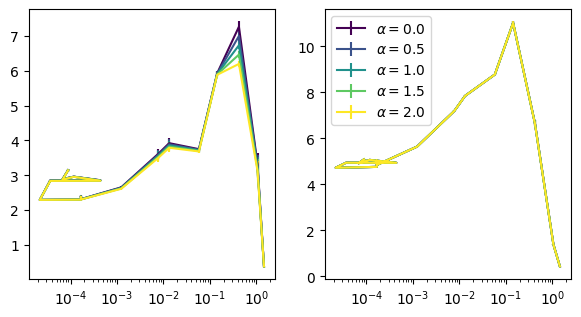

In [ ]:
kl_test = np.load('/home/amisery/scratch_link/grad_sample_fullsum/xxz_1.5/L16/RBM/alpha3/MC_9_0.5/0.0022_schedule/run_0/out_analysis_kl.npz', allow_pickle=True)['arr_0'].item()
fix, axes = plt.subplots(1, 2, figsize=(7,3.5))

for idx, alpha in enumerate(alpha_l):
    axes[0].errorbar(x  = kl_test['rel_err'], y= np.array(kl_test[alpha]['klf'])[:,0], yerr =  np.array(kl_test[alpha]['klf'])[:,1], color = colors[idx], label = r"$\alpha = %.1f$"%alpha)
    axes[0].set_xscale('log')
    axes[1].errorbar(x  = kl_test['rel_err'], y = np.array(kl_test[alpha]['klr'])[:,0], yerr =  np.array(kl_test[alpha]['klr'])[:,1], color = colors[idx], label = r"$\alpha = %.1f$"%alpha)
    axes[1].set_xscale('log')
plt.legend()

In [6]:
def op_snr(tree, func):
    leaves = jax.tree_util.tree_leaves(tree)
    return func(jnp.stack([func(leaf, axis=range(1, leaf.ndim)) for leaf in leaves]), axis=0)

In [5]:
def plot_snr_grad(save_dir, alpha_l, diag_shift):
    fig, axes = plt.subplots(1, 6, figsize=(20,4))
    colors = viridis(jnp.linspace(0, 1,len(alpha_l)))
    for idx, alpha in enumerate(alpha_l):
        data = np.load(save_dir + f'out_analysis_{alpha}_{diag_shift}.npz', allow_pickle=True)['arr_0'].item()
        rel_err = jnp.array(data['rel_err'])
        snr_ng = data['snr_ng']
        snr_grad = data['snr_grad']
        snr_e = jnp.array(data['snr_e'])
        fs_dist = data['fs_dist']
        
        for ax in axes.flat:
            ax.set_xlabel('Relative error')
            ax.set_xscale('log')
            ax.set_yscale('log')
        sorted_ind = jnp.argsort(rel_err)
        rel_err_s = rel_err[sorted_ind]
        op_snr(snr_ng, jnp.nanmin)
        axes[0].plot(rel_err[sorted_ind], snr_e[sorted_ind], color = colors[idx], label = alpha)
        axes[0].set_title(r'$\mathrm{SNR}(E)$')

        axes[1].plot(rel_err_s, op_snr(snr_ng, jnp.nanmin)[sorted_ind], color = colors[idx], label = alpha)
        axes[1].set_title(r'$\min_i \: \mathrm{SNR}[(S^{-1}F)_i]$')

        axes[2].plot(rel_err_s, op_snr(snr_ng, jnp.nanmean)[sorted_ind], color = colors[idx], label = alpha)
        axes[2].set_title(r'$\frac{1}{N_p}\sum_i \: \mathrm{SNR}[(S^{-1}F)_i]$')

        axes[3].scatter(rel_err_s, op_snr(snr_grad, jnp.nanmin)[sorted_ind], color = colors[idx], label = alpha, edgecolors='black')
        axes[3].set_title(r'$\min_i \: \mathrm{SNR}[F_i]$')

        axes[4].scatter(rel_err_s,  op_snr(snr_grad, jnp.nanmean)[sorted_ind], color = colors[idx], label = r"$\alpha = %.1f$"%alpha, edgecolors='black')
        axes[4].set_title(r'$\frac{1}{N_p}\sum_i \mathrm{SNR}[F_i]$')

        axes[5].plot(rel_err_s[1:],  jnp.var(fs_dist, axis=1)[1:][sorted_ind[1:]], color = colors[idx], label = r"$\alpha = %.1f$"%alpha)
        axes[5].set_title(r'$FS(S^{-1}F_{MC}, S^{-1}F_{Fullsum} )$')

    plt.legend(bbox_to_anchor=(1.2,1))
    fig.tight_layout()
    return fig

In [10]:
os.listdir('/home/amisery/scratch_link/grad_sample_fullsum/xxz_1.5/L16/RBM/alpha5/MC_9_0.5/0.0022_schedule/run_0/')

['out_analysis_1.5_1e-11.npz',
 'out_analysis_0.0_1e-11.npz',
 'out_analysis_1.0_1e-11.npz',
 'config.yaml',
 'out_analysis_0.5_1e-11.npz',
 'training.png',
 'state',
 'out_analysis_2.0_1e-11.npz']

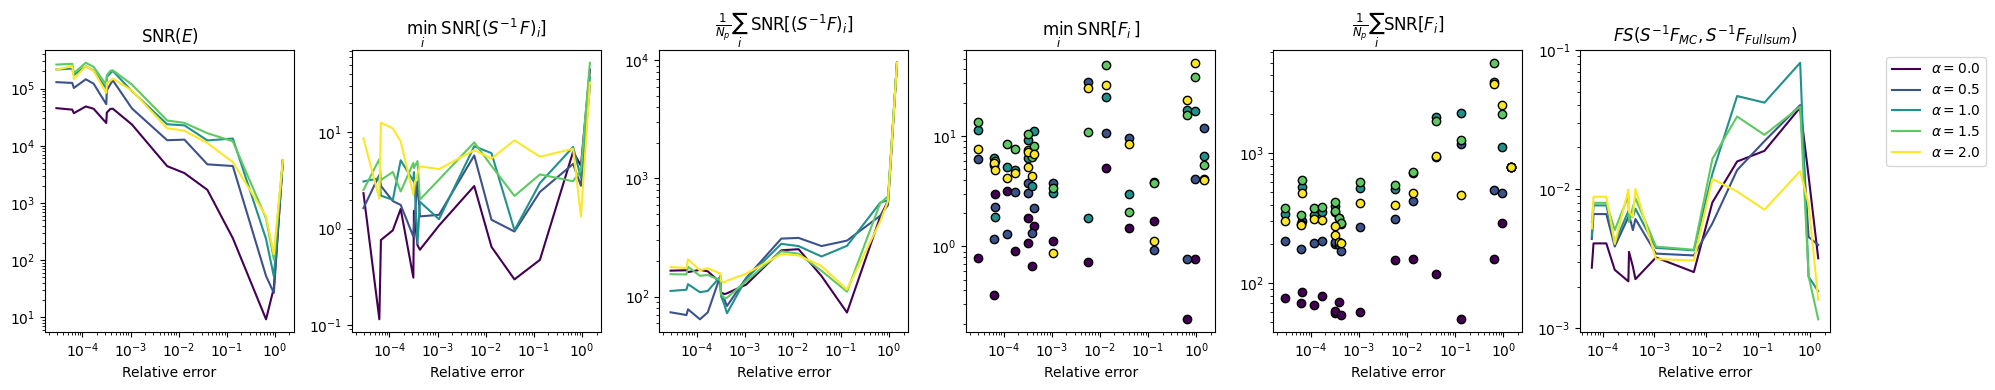

In [11]:
save_dir = '/home/amisery/scratch_link/grad_sample_fullsum/xxz_1.5/L16/RBM/alpha5/MC_9_0.5/0.0022_schedule/run_0/'
diag_shift= 1e-11
fig = plot_snr_grad(save_dir, alpha_l, diag_shift)

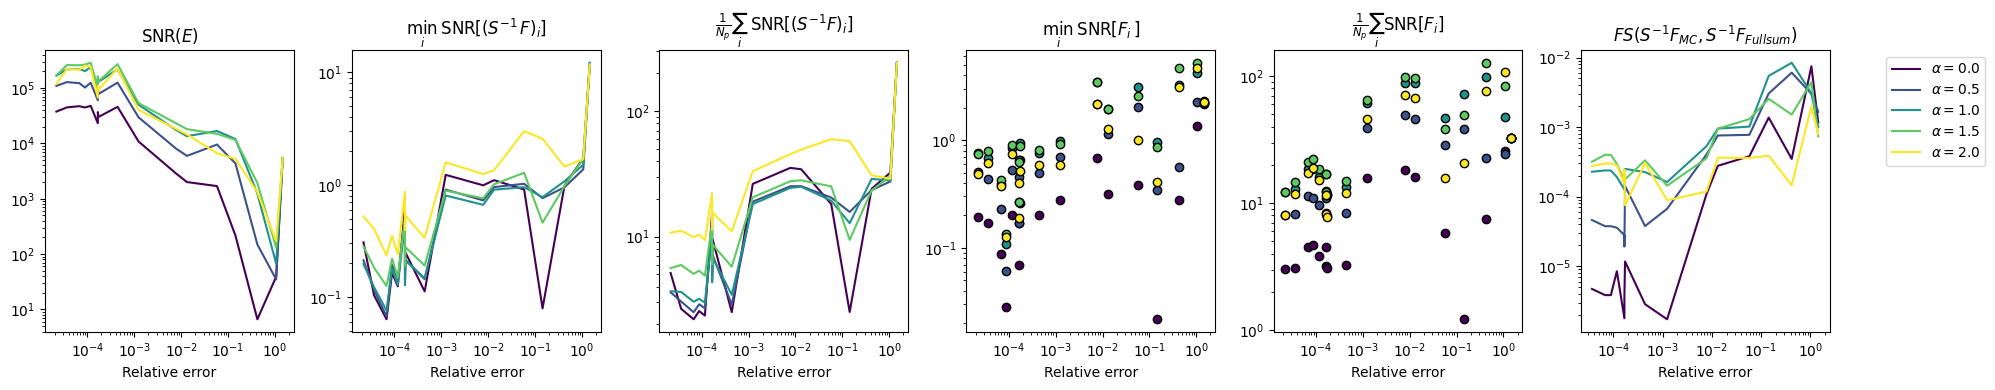

In [14]:
save_dir = '/home/amisery/scratch_link/grad_sample_fullsum/xxz_1.5/L16/RBM/alpha3/MC_9_0.5/0.0022_schedule/run_0/'
diag_shift= 1e-8
fig = plot_snr_grad(save_dir, alpha_l, diag_shift)

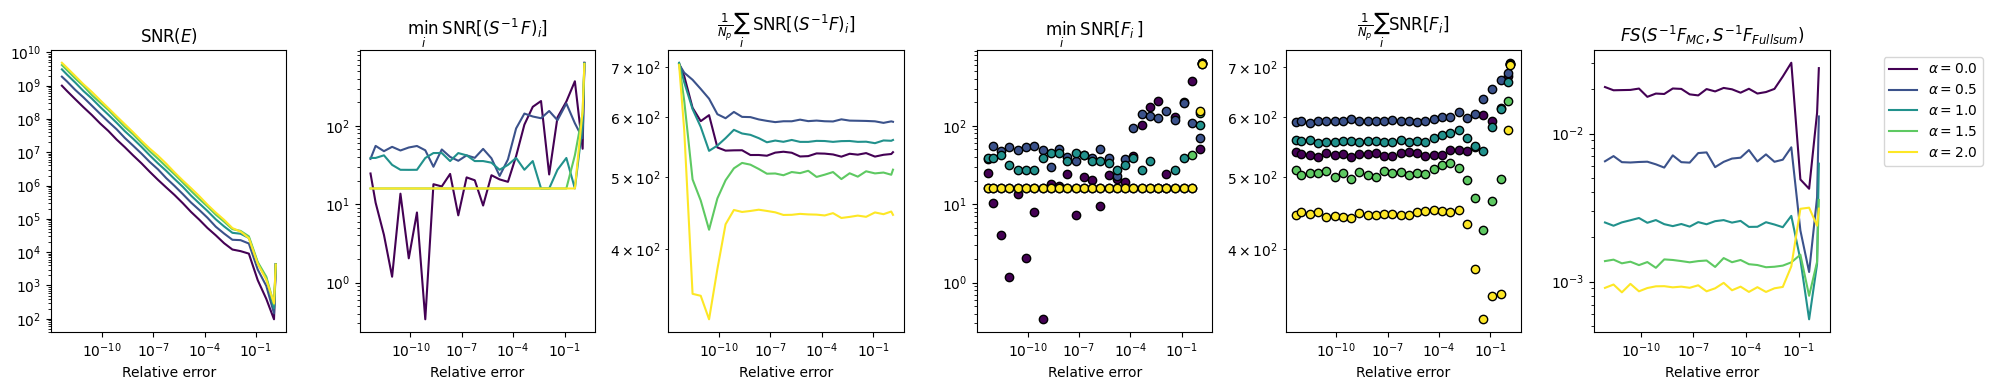

: 

In [62]:
save_dir = '/home/amisery/scratch_link/grad_sample_fullsum/xxz_1.5/L10/log_state/alpha0/0.001_1e-07/run_3/'
diag_shift= 1e-6
plot_snr_grad(save_dir, alpha_l, diag_shift)

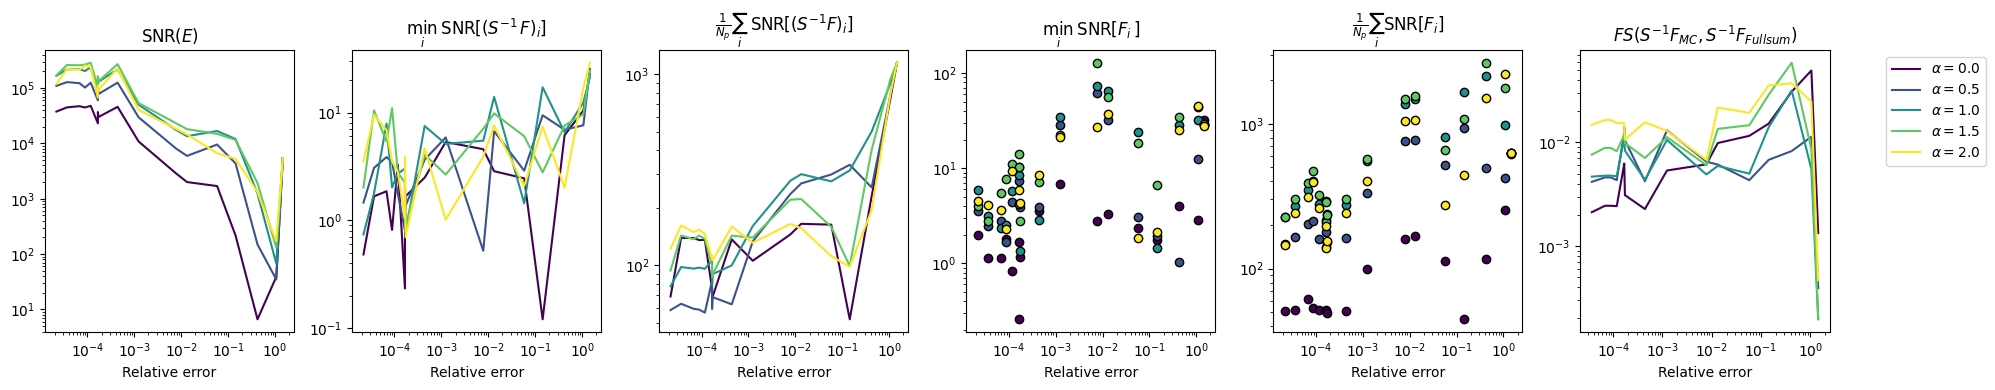

In [67]:
diag_shift = 1e-8
save_dir = '/home/amisery/scratch_link/grad_sample_fullsum/xxz_1.5/L16/RBM/alpha3/MC_9_0.5/0.0022_schedule/run_0/'
plot_snr_grad(save_dir, alpha_l, diag_shift)

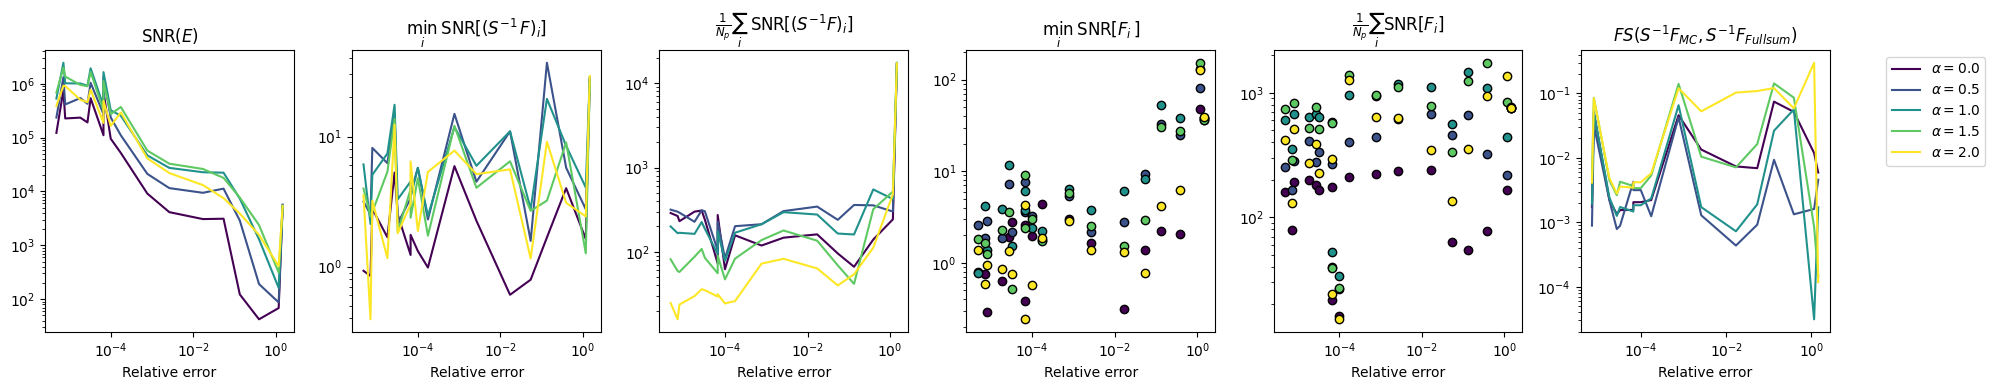

In [75]:
diag_shift = 1e-8
alpha_l_sym = [0.0, 0.5, 1.0, 1.5, 2.0]
save_dir = '/home/amisery/scratch_link/grad_sample_fullsum/xxz_1.5/L16/RBMSymm/alpha3/MC_9_2.0/0.0022_schedule/run_0/'
fig = plot_snr_grad(save_dir, alpha_l_sym, diag_shift)

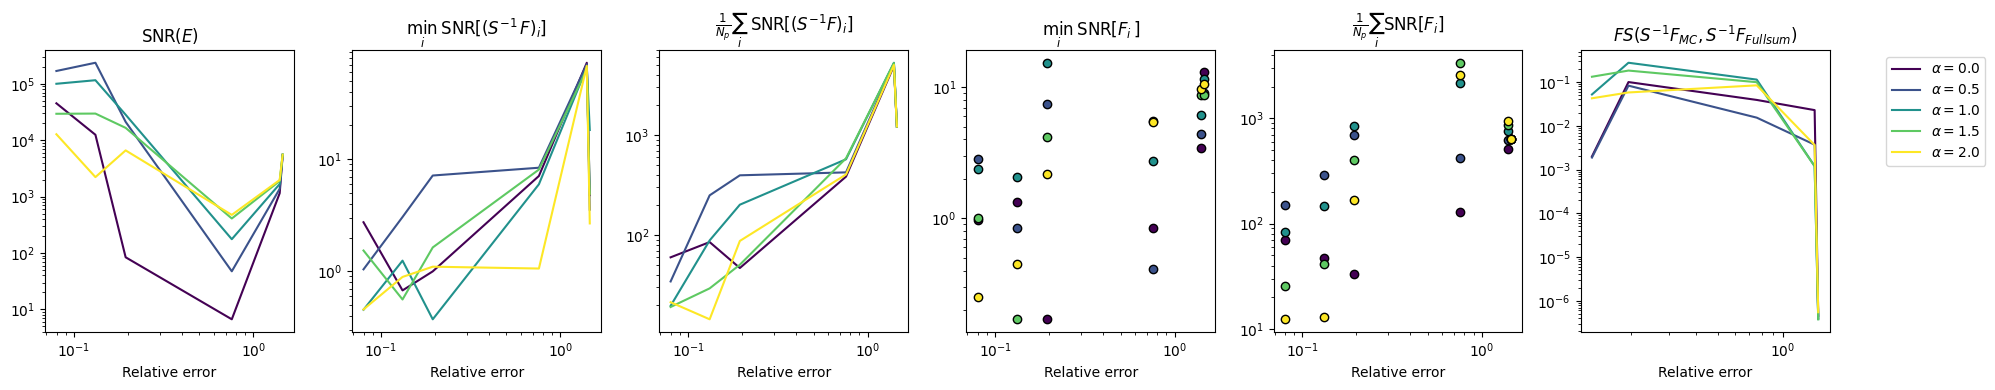

In [69]:
diag_shift = 1e-8
alpha_l_sym = [0.0, 0.5, 1.0, 1.5, 2.0]
save_dir = '/home/amisery/scratch_link/grad_sample_fullsum/xxz_1.5/L16/RBM/alpha3/MC_9_2.0/0.0022_schedule/run_0/'
plot_snr_grad(save_dir, alpha_l_sym, diag_shift)

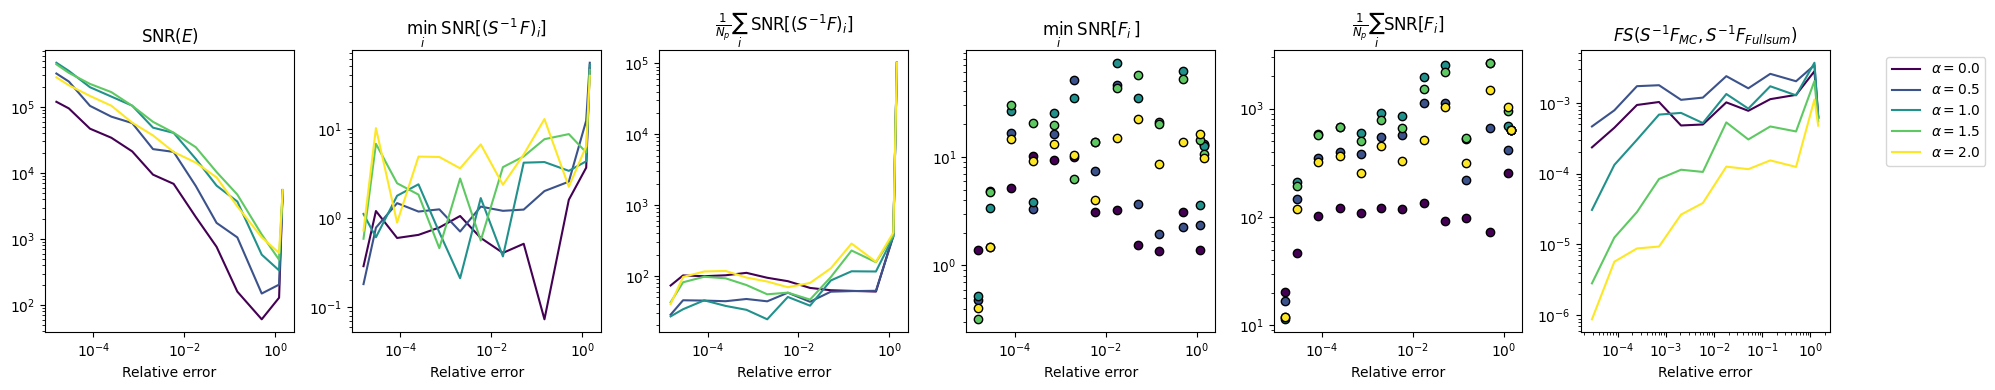

In [70]:
alpha_l = [0.0, 0.5, 1.0, 1.5, 2.0]
diag_shift = 1e-6
save_dir = '/home/amisery/scratch_link/grad_sample_fullsum/xxz_1.5/L16/RBM/alpha3/0.0022_1e-06/run_1/'
plot_snr_grad(save_dir, alpha_l, diag_shift)